Project 1 

In [2]:
using Distributions
using BayesNets
using PGFPlots
using DataFrames
using RDatasets
using LightGraphs
using GraphPlot
using TikzGraphs
using TikzPictures


INFO: Recompiling stale cache file C:\Users\Thomas\.julia\lib\v0.5\StatsBase.ji for module StatsBase.
INFO: Recompiling stale cache file C:\Users\Thomas\.julia\lib\v0.5\Distributions.ji for module Distributions.
INFO: Recompiling stale cache file C:\Users\Thomas\.julia\lib\v0.5\BayesNets.ji for module BayesNets.
INFO: Recompiling stale cache file C:\Users\Thomas\.julia\lib\v0.5\PGFPlots.ji for module PGFPlots.
INFO: Recompiling stale cache file C:\Users\Thomas\.julia\lib\v0.5\GraphPlot.ji for module GraphPlot.


In [4]:
# Load the data sets as data frames
schoolgrades = readtable("..\\project1\\schoolgrades.csv");
titanic = readtable("..\\project1\\titanic.csv");
whitewine = readtable("..\\project1\\whitewine.csv");

# Create a fully unconnected bayesian network
b = DiscreteBayesNet()
for name in names(schoolgrades)
    push!(b, DiscreteCPD(name, [0.1,0.9]))
end


First step: create a scoring function and check its validity with the already implemented one from BayesNets package.

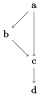

In [6]:
# create a random bayesian network (:a=>:b, :a=>:c, :b=>:c, :c=>:d) to test the scoring function
data = DataFrame(a=[1,1,1,2,1,1,2,1,1,2,1,1],
                 b=[1,1,1,2,2,2,2,1,1,2,1,1], 
                 c=[1,1,1,1,2,2,2,2,3,3,3,3],
                 d=[1,3,4,1,5,2,2,2,3,3,3,3]
                 )
bn = fit(DiscreteBayesNet, data, (:a=>:b, :a=>:c, :b=>:c, :c=>:d))


In [7]:
# bayesian score function
function bscore(dag,data)
    
    N = statistics(dag,data);
    n = size(data,2)
    parent_list = badj(dag);
    ncategories = Array(Int, n);    
    for i = 1 : n
        if isempty(parent_list[i]) # TO FIX
            q = 1;
        end
        ncategories[i] = infer_number_of_instantiations(convert(Vector{Int}, data[i]));       
    end
    # create alpha
    A = Array(Array{Int}, n);
    for i = 1 : n

        B = parent_list[i];
        l = length(B);
        dim2 = 1;
        for j = 1 : l 
            dim2 = dim2 * ncategories[B[j]]; 
        end
        if dim2 == 0
            dim2 =1;
        end
        A[i] = ones(ncategories[i],dim2);

    end
    alpha = A;

    function sumlgamma(A)
        ret = 0;
        l = length(A)
        for k = 1 : l
            t = length(A[k]);

            for m = 1 : t
                ret = ret + lgamma(A[k][m]);
            end
        end
        ret
    end
    function sumArray(A)
        n = length(A);
        ret = Array(Array{Int}, n); 
        for i = 1 : n
            ret[i] = sum(A[i],1); 
        end
        ret
    end
    sumlgamma(alpha + N) - sumlgamma(alpha) + sumlgamma(sumArray(A)) -  sumlgamma(sumArray(A)+sumArray(N))
end

bscore (generic function with 1 method)

K2 algorithm implementation from COOPER, 1992

In [8]:
## T.Hossler version of K2 algorithm
function kangchenjunga(data,max_parents,rp)
    nodes = names(data);
    #max_parents = 2;
    n  = size(data,2);
    #rp = [(i) for i = 1 : n];
    graph =  DiGraph(size(data,2)); # create an unconnected graph

    new_score = 0; # initialize the value of the score
    parent_list = zeros(n);


    for i = 1 : n # loop over the nodes
        old_score = bscore(graph,data);
        for j = i+1 : n # loop over the nodes
            if parent_list[i] < max_parents
                add_edge!(graph,rp[j],rp[i]) # create the edge - add a parent
                new_score = bscore(graph,data); # calculate the score with the newly created edge.
                if !is_cyclic(graph)
                    if new_score > old_score # if the score is better we keep this parent and update old_score
                        parent_list[i] = parent_list[i] +1;
                        old_score = new_score;

                    else
                        rem_edge!(graph,rp[j],rp[i])

                    end
                    p = parent_list[i];
                else
                    rem_edge!(graph,rp[j],rp[i])
                end
            end       
        end

    end
    graph
end

kangchenjunga (generic function with 1 method)

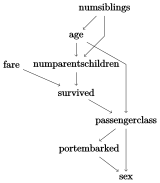

In [9]:
# Example on the Titanic data set
rp = randperm(size(titanic,2))
graphTitanic = kangchenjunga(titanic,2,rp)
TikzGraphs.plot(graphTitanic,["age", "portembarked", "fare" ,"numparentschildren", "passengerclass" ,"sex" ,"numsiblings", "survived"])



In [10]:
## local search algorithm
function graal(graph,data,tabu,ite)
    
    # inputs: 
    # - graph = dag obtained from k2 search
    # - tabu = size of the memory (number of pairs of nodes that the code remember)
    # - number of iterations to try after we found a local minima
    # output:
    # - dag
    numberOfNodes = size(data,2);
    listOfNodes1 = [(i) for i = 1 : numberOfNodes];
    listOfNodes2 = copy(listOfNodes1);
    
    iterations = 0;
    proceed = true;
    tabuList = Array(Int, tabu);
    ind = 1;

    iterations = 0;
    proceed = true;
    tabuList = zeros(Int,tabu);
    old_score = bscore(graph,data);
    print(is_cyclic(graph))
    graphIni = copy(graph);
    while proceed && iterations <= ite
        
        print(iterations)

        if sum(tabuList) > 0 # if the list is not empty, eg first round
            for j = 1 : length(tabuList)
                if tabuList[j] > 0
                    k = find(listOfNodes2 .== tabuList[j])
                    deleteat!(listOfNodes2,convert(Int,k[1])); # remove the node from the tabu list
                end
            end
        end

        node1Ind = convert(Int,floor(length(listOfNodes2)*rand()+1)); # randonly select two nodes from the remaining
        node1 = listOfNodes2[node1Ind]; 
        node2Ind = convert(Int,floor(length(listOfNodes2)*rand()+1));
        node2 = listOfNodes2[node2Ind];
        convert(Int,node1); convert(Int,node2);

        # save the nodes in the tabulist
        if ind < tabu 
            tabuList[ind] = node1; tabuList[ind+1] = node2; 
            ind = ind+2;
        elseif ind == tabu
            tabuList[ind] = node1;
            ind = 1;
            tabuList[ind] = node2;
            ind = ind+2;
        else  
            ind = 1;
            tabuList[ind] = node1; tabuList[ind+1] = node2;
            ind = ind+2;
        end

        neighborsNode1 = badj(graph,node1); a = find(neighborsNode1 .== node2);
        neighborsNode2 = badj(graph,node2); b = find(neighborsNode2 .== node1);

        if !isempty(a)  # there is an edge between the nodes node2 -> node1
            score1 = bscore(graph,data);
            rem_edge!(graph,node2,node1);# remove the edge
            score2 = bscore(graph,data); 
            add_edge!(graph,node1,node2); # inverse the edge
            score3 = bscore(graph,data);
            score = [score1,score2,score3];
            j = find(score .== maximum(score)); 
            print(score)
            if maximum(score) >= old_score[1]
                if j == 1 # we did not anything
                    rem_edge!(graph,node1,node2);
                    add_edge!(graph,node2,node1);
                    iterations += 1;
                    old_score = score[j];
                elseif j == 2
                    rem_edge!(graph,node1,node2);
                    if is_cyclic(graph) # if the graph is the cyclic we reverse to the former one
                        add_edge!(graph,node2,node1);
                        iterations += 1;
                        old_score = score1;
                        print("cyclic")
                    else
                        proceed = true;
                        old_score = score[j];
                    end

                else
                    if is_cyclic(graph)
                        rem_edge!(graph,node1,node2);
                        add_edge!(graph,node2,node1);
                        iterations += 1;
                        old_score = score1;
                        print("cyclic")
                    else
                        proceed = true;
                        old_score = score[j];                        
                    end

                end
            end
            
        elseif !isempty(b)  #there is an edge between the nodes node1 -> node2
            score1 = bscore(graph,data);
            rem_edge!(graph,node1,node2);# remove the edge
            score2 = bscore(graph,data); 
            add_edge!(graph,node2,node1); # inverse the edge
            score3 = bscore(graph,data);
            score = [score1,score2,score3];
            j = find(score .== maximum(score));
            print(score)
            if maximum(score) >= old_score[1]
                if j == 1 
                    rem_edge!(graph,node2,node1);
                    add_edge!(graph,node1,node2);
                    iterations += 1;
                    old_score = score[j];
                elseif j == 2
                    rem_edge!(graph,node1,node2);
                    if is_cyclic(graph)
                        add_edge!(graph,node1,node2)
                        iterations += 1;
                        old_score = score1;
                        print("cyclic")
                    else
                        proceed = true;
                        old_score = score[j];
                    end
                else
                    if is_cyclic(graph)
                        rem_edge!(graph,node2,node1);
                        add_edge!(graph,node1,node2)
                        iterations += 1;
                        old_score = score1;
                        print("cyclic")
                    else
                        proceed = true;
                        old_score = score[j];
                    end
                end
            end
            
        else #create the edge
            score1 = bscore(graph,data);
            add_edge!(graph,node1,node2);
            score2 = bscore(graph,data);
            rem_edge!(graph,node1,node2);
            add_edge!(graph,node2,node1);
            score3 = bscore(graph,data);
            score = [score1,score2,score3];
            j = find(score .== maximum(score));
            print(score)
            if maximum(score) >= old_score[1]    
                if j == 1 # we did not anything
                    rem_edge!(graph,node2,node1);
                    iterations += 1;
                    old_score = score[j];
                elseif j == 2
                    rem_edge!(graph,node2,node1);
                    add_edge!(graph,node1,node2);
                    if is_cyclic(graph)
                        rem_edge!(graph,node1,node2)
                        iterations += 1;
                        old_score = score1;
                        print("cyclic")
                    else
                        proceed = true;
                        old_score = score[j];
                    end
                else
                    if is_cyclic(graph)
                        rem_edge!(graph,node2,node1)
                        iterations += 1;
                        old_score = score1; 
                        print("cyclic")
                    else
                        proceed = true;
                        old_score = score[j];
                    end
                end
            end
        end
        
        listOfNodes2 = copy(listOfNodes1);    
        
    iterations += 1;    
    end
   
    graph
end

graal (generic function with 1 method)

To find the struture, we first run a K2 algorithm and then a local search algorithm on the found structure.

In [26]:
################################################### MAIN CODE ##################################################################
## 3 functions
# - bscore(graph,data) = bayesian score
# - kangchenjunga(data,max_parents,rp) = K2 algorithm
# - graal(graph,data,tabu,ite) = local search

tic();
data = titanic; # define the data set
numberOfDAG = 10000;
rp = Array{Int}(numberOfDAG,size(data,2));
for i = 1 : numberOfDAG
    rp[i,:] = randperm(size(data,2)); 
end
old_score = -Inf;

tabu = 4;
ite = 5;
new_score2 = 0;
old_graph = Graph();
old_graph2 = Graph();
new_graph = Graph();
count = 0;

for i = 1 : numberOfDAG
    print(i)
    old_graph = kangchenjunga(data,2,rp[i,:]);
    new_score1 = bscore(old_graph,data);
    if new_score1 >= old_score # the new graph is better       
        new_graph = copy(old_graph);
        old_score = new_score1;
        #old_graph2 = graal(old_graph,data,tabu,ite);
        #new_score2 = bscore(old_graph2,data);

        #if new_score2 >= new_score1 # if local search improve k2            
            #old_score = new_score2;
            #new_graph = copy(old_graph2);            
        #end
    end
    
end
old_score
time = toc();


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

489.159799825

-3808.842432821988